In [ ]:
# Import libraries
import jax
from jax import grad, vmap, random, jit
import jax.numpy as jnp
from jax.example_libraries import optimizers
import neural_tangents as nt
from neural_tangents import stax
import matplotlib.pyplot as plt

In [120]:
# Create dataset using two points and x test set for plotting
x_train = jnp.linspace(0,1,128).reshape(-1,1)
y_train = 1-2*x_train

x_test = jnp.linspace(-2,2,100).reshape(-1,1)

In [167]:
# Define NN to be used

init_fn, apply_fn, kernel_fn = stax.serial(
    stax.Dense(512, W_std=1.5, b_std=0), stax.ElementwiseNumerical(jax.nn.tanh, deg=100),
    stax.Dense(512, W_std=1.5, b_std=0), stax.ElementwiseNumerical(jax.nn.tanh, deg=100),
    stax.Dense(1, W_std=1.5, b_std=0)
)

apply_fn = jit(apply_fn)
kernel_fn = jit(kernel_fn, static_argnames='get')

c:\Users\thoma\miniconda3\envs\neutang\Lib\site-packages\neural_tangents\_src\stax\elementwise.py:1171: UserWarning: Numerical Activation Layer with fn=<PjitFunction of <function tanh at 0x000002255EE66660>>, deg=100 used!Note that numerical error is controlled by `deg` and for a giventolerance level, required `deg` will highly be dependent on the choiceof `fn`.
  warnings.warn(


In [168]:
# Plot prior distributions on data

priors = []

key = random.key(42)
for _ in range(100):
    key, pri_key = random.split(key, 2)
    _, params = init_fn(pri_key, (-1,1))
    priors += [apply_fn(params, x_test)]
priors = jnp.array(priors)

In [169]:
# Use NTK to get errors in initialisation
kernel = kernel_fn(x_test, x_test, 'ntk')
std_dev = jnp.sqrt(jnp.diag(kernel))

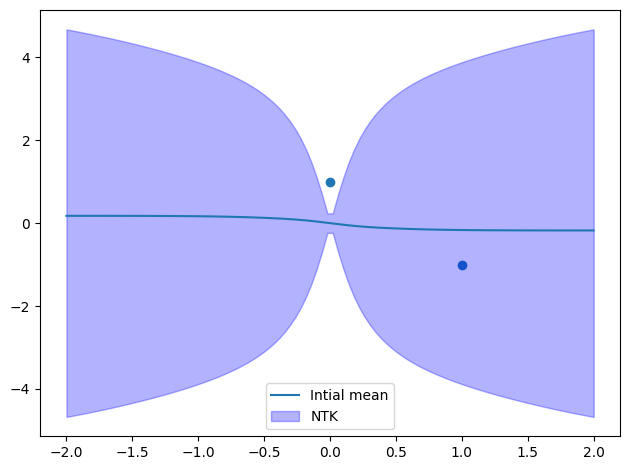

In [170]:
# Plot results thus far
plt.scatter(x_train[jnp.array([0,-1])], y_train[jnp.array([0,-1])])
plt.plot(x_test, jnp.mean(priors, axis=0), label="Intial mean")
plt.fill_between(x_test.reshape(-1), -2*std_dev, 2*std_dev, color='b', alpha=0.3, label="NTK")
plt.legend()
plt.tight_layout()
plt.show()

In [171]:
# Create predictor for data
predict_fn = nt.predict.gradient_descent_mse_ensemble(kernel_fn, x_train, y_train, diag_reg=1e-4)

ts = jnp.array([16, 256, 65536])

ntk_means, ntk_covs = predict_fn(t=ts, x_test=x_test, get='ntk', compute_cov=True)
nngp_mean, nngp_cov = predict_fn(t=ts[-1], x_test=x_test, get='nngp', compute_cov=True)


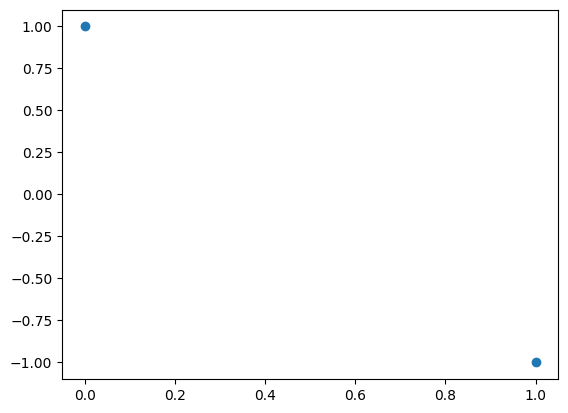

In [172]:
plt.plot(x_test, ntk_means[2])
plt.scatter(x_train[jnp.array([0,-1])], y_train[jnp.array([0,-1])])